In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/preprocessed_rapido_dataset.csv")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, auc
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df.columns

Index(['booking_id', 'day_of_week', 'is_weekend', 'hour_of_day', 'city',
       'pickup_location', 'drop_location', 'vehicle_type', 'ride_distance_km',
       'estimated_ride_time_min', 'actual_ride_time_min', 'traffic_level',
       'weather_condition', 'base_fare', 'surge_multiplier', 'booking_value',
       'booking_status', 'incomplete_ride_reason', 'customer_id', 'driver_id',
       'preferred_vehicle_type', 'cancellation_rate', 'avg_customer_rating',
       'customer_cancel_flag', 'driver_age', 'driver_city',
       'driver_experience_years', 'delay_count', 'acceptance_rate',
       'avg_driver_rating', 'avg_pickup_delay_min', 'driver_delay_flag',
       'total_requests', 'completed_rides', 'cancelled_rides',
       'avg_wait_time_min', 'avg_surge_multiplier', 'demand_level',
       'peak_hour_flag', 'fare_per_km', 'fare_per_min', 'long_distance_flag',
       'city_pair', 'driver_reliability_score', 'customer_loyalty_score',
       'booking_datetime'],
      dtype='object')

In [5]:
# Selecting columns for modeling - Feature selection based on domain knowledge and EDA insights
ride_outcome_selected_cols = [
    'day_of_week',
    'is_weekend',
    'hour_of_day',
    'city',
    'vehicle_type',
    'ride_distance_km',
    'estimated_ride_time_min',
    'traffic_level',
    'weather_condition',
    'base_fare',
    'surge_multiplier',
    'booking_value',
    'booking_status',
    'customer_cancel_flag',
    'driver_experience_years',
    'driver_delay_flag',
    'total_requests',
    'avg_wait_time_min',
    'avg_surge_multiplier',
    'demand_level',
    'peak_hour_flag',
    'fare_per_km',
    'fare_per_min',
    'long_distance_flag',
    'driver_reliability_score',
    'customer_loyalty_score'
    ]

selected_df = df[ride_outcome_selected_cols]
# Splitting the dataset into features and target variable

X = selected_df.drop(columns=['booking_status'])

le = LabelEncoder()
y = le.fit_transform(selected_df['booking_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

In [6]:
# Feature groups for preprocessing
# Continuous features to scale
ride_outcome_numeric_cols = [
    "total_requests",
    "avg_wait_time_min",
    "base_fare",
    "surge_multiplier",
    "avg_surge_multiplier",
    "ride_distance_km",
    "estimated_ride_time_min",
    "booking_value",
    "fare_per_km",
    "fare_per_min",
    "customer_loyalty_score",
    "driver_experience_years",
    "driver_reliability_score"
]

# Categorical features to encode (One Hot encoder can be used for these)
ride_outcome_categorical_cols = [
    "vehicle_type",
    "city",
    "weather_condition",
    "day_of_week",
    "hour_of_day"
]

# Ordinal encoding
ordinal_cols = [
    "demand_level",
    "traffic_level"
]

# As is binary features
binary_cols = [
    "peak_hour_flag",
    "long_distance_flag",
    "customer_cancel_flag",
    "driver_delay_flag",
    "is_weekend"
]

# Ensure all values are strings
for col in ride_outcome_categorical_cols + ordinal_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Ordered encoding for demand and traffic levels
demand_mapping = ["Low","Medium"]
traffic_mapping = ["Low","Medium","High"]

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
ordinal_transformer = OrdinalEncoder(categories=[demand_mapping, traffic_mapping])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ride_outcome_numeric_cols),
        ('cat', categorical_transformer, ride_outcome_categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='passthrough'  # keep binary features as is
)   

dt_rf_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ride_outcome_categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='passthrough'  # keep binary features as is
)   

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.58      0.51      4657
           1       0.86      0.59      0.70     13669
           2       0.18      0.51      0.27      1674

    accuracy                           0.58     20000
   macro avg       0.50      0.56      0.49     20000
weighted avg       0.71      0.58      0.62     20000

Logistic Regression Accuracy: 0.5832


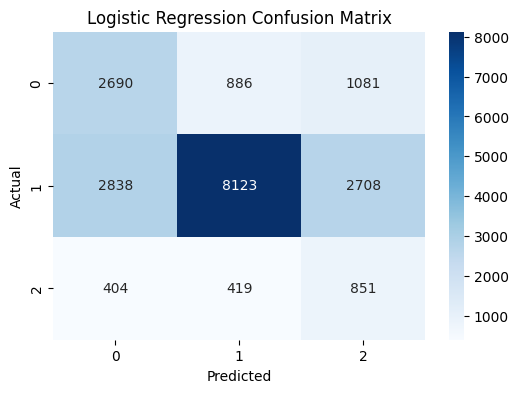

Logistic Regression F1 Score: 0.6216


In [7]:
# Fit Pipeline with models and evaluate performance
# Logistic Regression Pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('time_features', SelectKBest(score_func=f_classif, k=20)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

logistic_pipeline.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_logistic = logistic_pipeline.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))   

# Accuracy Score
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")

# Confusion Matrix
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# F1 Score
f1_logistic = f1_score(y_test, y_pred_logistic , average='weighted')
print(f"Logistic Regression F1 Score: {f1_logistic:.4f}")



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.37      0.37      4657
           1       0.75      0.75      0.75     13669
           2       0.15      0.17      0.16      1674

    accuracy                           0.61     20000
   macro avg       0.43      0.43      0.43     20000
weighted avg       0.61      0.61      0.61     20000

Decision Tree Accuracy: 0.6099


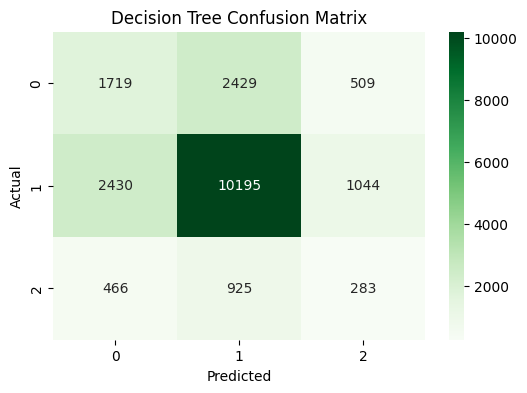

Decision Tree F1 Score: 0.6118


In [8]:
# Create a pipeline that combines preprocessing with a Decision Tree Classifier
tree_pipeline = Pipeline(steps=[
    ('preprocessor', dt_rf_preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])
tree_pipeline.fit(X_train, y_train)
y_pred_tree = tree_pipeline.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

# Accuracy Score
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.4f}")
# Confusion Matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# F1 Score
f1_tree = f1_score(y_test, y_pred_tree , average='weighted')
print(f"Decision Tree F1 Score: {f1_tree:.4f}")




Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.43      4657
           1       0.75      0.92      0.83     13669
           2       0.40      0.03      0.05      1674

    accuracy                           0.71     20000
   macro avg       0.56      0.44      0.44     20000
weighted avg       0.67      0.71      0.67     20000

Random Forest Accuracy: 0.7149


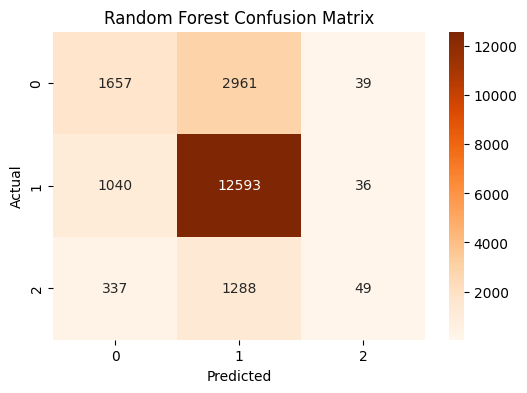

Random Forest F1 Score: 0.6691


In [9]:
# Create a pipeline that combines preprocessing with a Random Forest classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', dt_rf_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# F1 Score
f1_rf = f1_score(y_test, y_pred_rf , average='weighted')
print(f"Random Forest F1 Score: {f1_rf:.4f}")


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_pipeline = Pipeline(steps=[
    ('preprocessor', dt_rf_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': ['balanced']
}


grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='f1_weighted', verbose=2)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 500}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.56      0.53      4657
           1       0.80      0.82      0.81     13669
           2       0.33      0.17      0.22      1674

    accuracy                           0.70     20000
   macro avg       0.54      0.51      0.52     20000
weighted avg       0.69      0.70      0.69     20000

Random Forest Accuracy: 0.7022


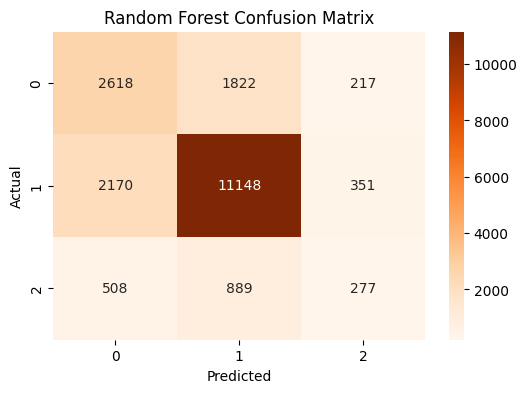

Random Forest F1 Score: 0.6945


In [ ]:
# Create a pipeline that combines preprocessing with a Random Forest classifier using the best hyperparameters from GridSearchCV
rf_pipeline = Pipeline(steps=[
    ('preprocessor', dt_rf_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# F1 Score
f1_rf = f1_score(y_test, y_pred_rf , average='weighted')
print(f"Random Forest F1 Score: {f1_rf:.4f}")
